In [26]:
import tensorflow as tf
import keras
import numpy as np 
import pandas as pd
from os import listdir
from os.path import isfile, join


from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate, GlobalAveragePooling2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model

from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
mypath = '/home/gustavo/Documents/teste/Lixo/R'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
lixo =[]

for files in onlyfiles:
    files = files.replace('_R.fits.fz', '')
    lixo.append(files)

mypath = '/home/gustavo/Documents/teste/Bons/R'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
bons =[]

for files in onlyfiles:
    files = files.replace('_R.fits.fz', '')
    bons.append(files)

In [8]:
def read_spectograms(file_paths, img_rows, img_cols, channels):
  """
  Reads the spectogram files from disk and normalizes the pixel values
    @params:
      file_paths - Array of file paths to read from
      img_rows - The image height.
      img_cols - The image width.
      as_grey - Read the image as Greyscale or RGB.
      channels - Number of channels.
    @returns:
      The created and compiled model (Model)        
  """
  images = []
  
  for file_path in file_paths:
    images.append(imread(file_path))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / 255.0 #np.max(images)
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images

In [28]:
path_b = '/home/gustavo/Documents/teste/imagens/Bons'
path_l = '/home/gustavo/Documents/teste/imagens/Lixo'

label = []
path_geral = []

for ind in bons:
    to_app = f'{path_b}/{ind}.jpg'
    path_geral.append(to_app)
    label.append(1)
    
for ind in lixo:
    to_app = f'{path_l}/{ind}.jpg'
    path_geral.append(to_app)
    label.append(0)

In [48]:
in_channel = 3
img_rows, img_cols = 128, 128
num_classes = 2 # number of appliances

batch_size = 10
epochs = 100
input_shape = (img_rows, img_cols, in_channel)
input_img = Input(shape = input_shape)

In [32]:
trainset = read_spectograms(path_geral, img_rows, img_cols, in_channel)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(trainset, label, test_size = 0.4, random_state=666)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.4, random_state=666)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [66]:
def create_convolution_layers(input_img):
  model = Conv2D(512, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = MaxPooling2D((2, 2),padding='same')(model)

  model = Conv2D(512, (3, 3), padding='same')(model)
  model = MaxPooling2D((2, 2),padding='same')(model)

  model = Conv2D(256, (3, 3), padding='same')(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    
  model = Conv2D(128, (3, 3), padding='same')(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)

  return model

In [67]:

# current_input = Input(shape=input_shape)
# current_model = base_model(current_input)
# current_model = GlobalAveragePooling2D()(current_model)

voltage_input = Input(shape=input_shape)

voltage_model = create_convolution_layers(voltage_input)


#conv = concatenate([current_model, voltage_model])

dense = Flatten()(voltage_model)
dense = Dense(1024)(dense)
# dense = BatchNormalization()(dense)
dense = Dropout(0.2)(dense)
dense = Dense(256)(dense)

dense = BatchNormalization()(dense)

output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs= voltage_input, outputs=output)

In [45]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         zoom_range = 0.1,
                         rotation_range = 40)

genX1 = gen.flow(x_train, y_train,  batch_size=batch_size,seed=666)

## ------- ##
gen_test = ImageDataGenerator()
genX1_test = gen.flow(x_test, y_test,  batch_size=batch_size,seed=666)


## ------- ##
gen_val = ImageDataGenerator()

genX1_val = gen.flow(x_val, y_val,  batch_size=batch_size,seed=666)

In [69]:
lr = 1e-3
decay_rate = (lr / 10)
momentum = 0.3

opt = optimizers.RMSprop()

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [70]:
history = model.fit(genX1,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    shuffle=False)

Epoch 1/10
1006/1006 [==============================] - 147s 146ms/step - loss: 0.1661 - accuracy: 0.9555 - val_loss: 0.2061 - val_accuracy: 0.9550
Epoch 2/10
1006/1006 [==============================] - 147s 146ms/step - loss: 0.1035 - accuracy: 0.9750 - val_loss: 0.1363 - val_accuracy: 0.9669
Epoch 3/10
1006/1006 [==============================] - 152s 151ms/step - loss: 0.0854 - accuracy: 0.9791 - val_loss: 0.3741 - val_accuracy: 0.9092
Epoch 4/10
1006/1006 [==============================] - 150s 150ms/step - loss: 0.0829 - accuracy: 0.9783 - val_loss: 0.1422 - val_accuracy: 0.9684
Epoch 5/10
1006/1006 [==============================] - 148s 147ms/step - loss: 0.0781 - accuracy: 0.9813 - val_loss: 0.2726 - val_accuracy: 0.9411
Epoch 6/10
1006/1006 [==============================] - 147s 146ms/step - loss: 0.0779 - accuracy: 0.9810 - val_loss: 0.1966 - val_accuracy: 0.9567
Epoch 7/10
1006/1006 [==============================] - 148s 147ms/step - loss: 0.0774 - accuracy: 0.9802 - val_

In [82]:
pred = model.predict(x_val)

In [87]:
pred

array([[9.9994171e-01],
       [3.3083122e-06],
       [1.2521424e-04],
       ...,
       [3.0999965e-07],
       [7.6989500e-06],
       [9.9997616e-01]], dtype=float32)

In [74]:
from sklearn.metrics import classification_report, confusion_matrix

In [98]:
def get_array_labels(array):
  Label_y_pred = []
  for x in array:
    if x <= 0.5:
      Label_y_pred = np.append(Label_y_pred,'Trash')
    if x > 0.5:
      Label_y_pred = np.append(Label_y_pred,'Good')
  return Label_y_pred

Label_y_pred = get_array_labels(pred)
Label_y_true = get_array_labels(y_val)

cnf_matrix = confusion_matrix(Label_y_pred, Label_y_true, labels=['Trash', 'Good'])

In [99]:
cnf_matrix

array([[1289,    8],
       [   0, 1385]])

Normalized confusion matrix


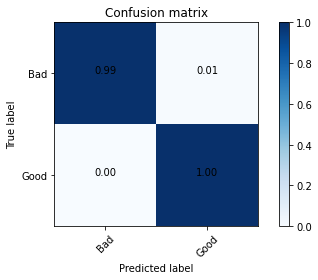

In [101]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    x = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    return x

cnf_matrix = confusion_matrix(Label_y_pred, Label_y_true, labels=['Trash', 'Good'])

zeta = plot_confusion_matrix(cnf_matrix, classes=['Bad', 'Good'], title='Confusion matrix', normalize=True)

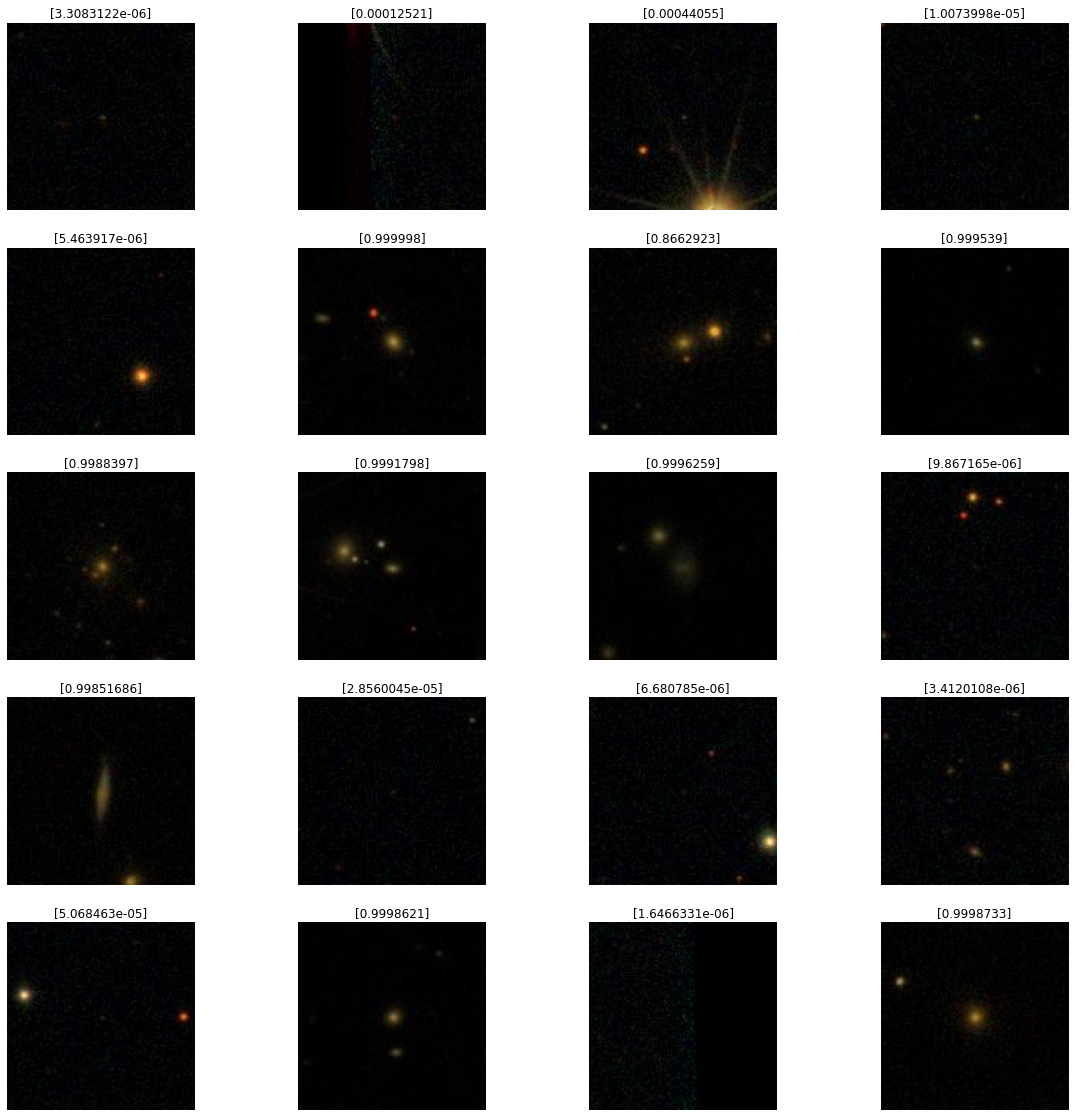

In [123]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = x_val[i]
    ax = fig.add_subplot(rows, columns, i, )
    ax.set_title(f'{pred[i]}')
    ax.axis('off')
    plt.imshow(img)
    
plt.show()

In [104]:
y_val

array([1, 0, 0, ..., 0, 0, 1])

In [130]:
selected = []
img_val = []

for key, x in enumerate(pred):
    if x > 0.15 and x < 0.85:
        selected.append(x)
        img_val.append(x_val[key])
        
selectednp = np.array(selected)
img_val = np.array(img_val)

In [131]:
img_val.shape

(30, 128, 128, 3)

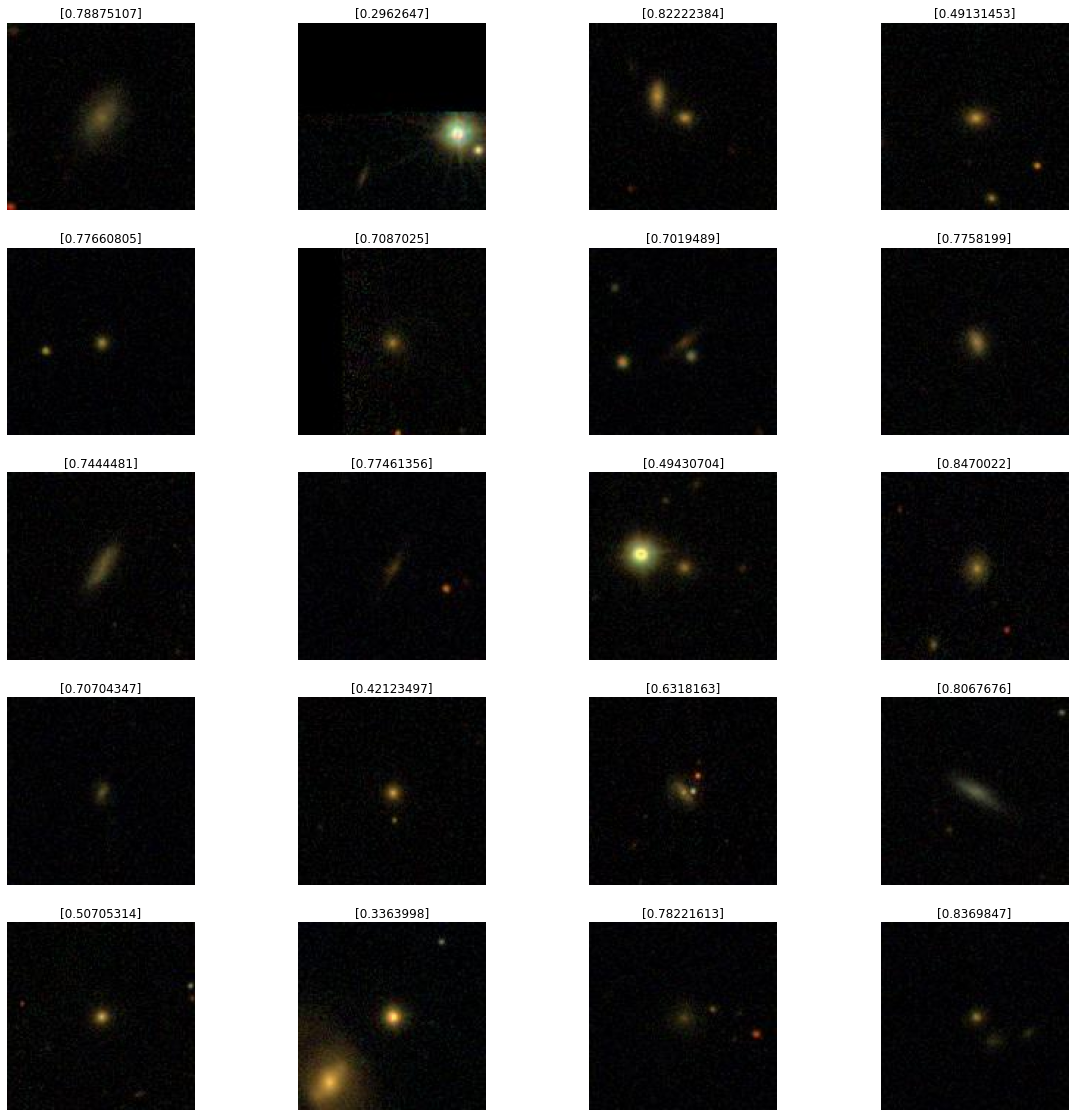

In [132]:
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = img_val[i]
    ax = fig.add_subplot(rows, columns, i, )
    ax.set_title(f'{selected[i]}')
    ax.axis('off')
    plt.imshow(img)
    
plt.show()

In [ ]:
model.save('/home/gustavo/NN-SPLUS/Notebooks/Tr')